In [2]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
from __future__ import unicode_literals

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

# Data

In [3]:
from data import load_data

In [4]:
X, y = load_data()

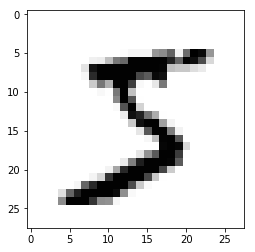

In [5]:
plt.imshow(X[0].reshape(28,28), cmap='Greys')
plt.show()

In [6]:
from PIL import Image

In [7]:
def skew(X, z):
    X_rotated = np.empty_like(X)
    for i in range(X.shape[0]):
        x = X[i].reshape(28,28)
        img = Image.fromarray(x)
        img = img.rotate(z, resample=Image.BICUBIC)
        x = np.array(img)
        X_rotated[i] = x.reshape(28,28,1)
    return X_rotated

In [8]:
X_rot = skew(X, 50)

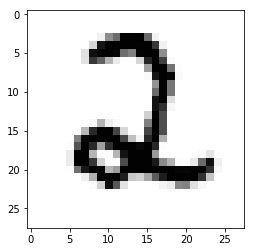

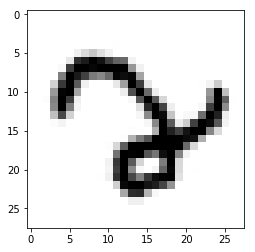

In [50]:
i = 378
plt.imshow(X[i].reshape(28,28), cmap='Greys')
plt.show()
plt.imshow(X_rot[i].reshape(28,28), cmap='Greys')
plt.show()


# Workflow

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
import datetime
import sys

def print(*args, sep=' ', flush=False, end='\n', file=sys.stdout):
    now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    __builtin__.print(now, *args, sep=sep, flush=flush, end=end, file=file)

In [17]:
def test_model(model, X, y):
    print('testing ...')
    pred = model.predict(X)
    acc = accuracy_score(y, pred)
    print('accuracy :', acc)
    print('finished testing')
    return acc
    

In [36]:
from sklearn.model_selection import ShuffleSplit

RANDOM_STATE = 42
def get_cv_iter(X, y):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=RANDOM_STATE)
    cv_iter = list(cv.split(X, y))
    return cv_iter

In [37]:
def train_submission(model, X, y):
    cv_iter = get_cv_iter(X, y)
    n_cv = len(cv_iter)
    for i, (idx_dev, idx_valid) in enumerate(cv_iter):
        X_train = X[idx_dev]
        y_train = y[idx_dev]
        
        print('training {}/{}...'.format(i+1, n_cv))
        model.fit(X, y)
        print('saving model {}/{}...'.format(i+1, n_cv))
        model.save('lin-{}.pkl'.format(i))
    return None

In [45]:
def test_submission(models, X, y, z_list=(-45, 0, +45)):
    cv_iter = get_cv_iter(X, y)
    n_cv = len(cv_iter)
    df_list = []
    for i, (idx_dev, idx_valid) in enumerate(cv_iter):
        X_test = X[idx_valid]
        y_test = y[idx_valid]
        res = []
        model = models[i]
        print('testing model {}/{}'.format(i+1, n_cv))
        for z in z_list:
            X_t = skew(X_test, z=z)
            pred = model.predict(X_test)
            acc = accuracy_score(y_test, pred)
            res.append((z, acc))
        df = pd.DataFrame(res, columns=['z', 'accuracy'])
        df_list.append(df)
    return df_list

# Model

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.externals import joblib

class LinReg(BaseEstimator, ClassifierMixin):
    def __init__(self):
        super().__init__()
        self.model = LogisticRegression()
    
    def get_name(self):
        return 'LinReg'
    
    def fit(self, X, y):
        X = X.reshape(-1, 28*28)
        X = X[:5000]
        y = y[:5000]
        X = X / 255
        self.model.fit(X, y)
        return self
    
    def predict_proba(self, X):
        X = X.reshape(-1, 28*28)
        X = X / 255
        pred = self.model.predict_proba(X)
        return pred
    
    def predict(self, X):
        X = X.reshape(-1, 28*28)
        X = X / 255
        pred = self.model.predict(X)
        return pred
    
    def save(self, dir_path):
        path = os.path.join(dir_path, 'LogisticRegression.pkl')
        joblib.dump(self.model, path)
        return self
    
    def load(self, dir_path):
        path = os.path.join(dir_path, 'LogisticRegression.pkl')
        self.model = joblib.load(path)
        return self



# Let's try it out

In [41]:
from sklearn.model_selection import train_test_split

model = LinReg()

In [42]:
train_submission(model, X, y)

2017-11-14 20:49:13 training 0/5...
2017-11-14 20:49:14 saving model 0/5...
2017-11-14 20:49:14 training 1/5...
2017-11-14 20:49:15 saving model 1/5...
2017-11-14 20:49:15 training 2/5...
2017-11-14 20:49:16 saving model 2/5...
2017-11-14 20:49:16 training 3/5...
2017-11-14 20:49:17 saving model 3/5...
2017-11-14 20:49:17 training 4/5...
2017-11-14 20:49:18 saving model 4/5...


In [43]:
models = [LinReg().load('lin-{}.pkl'.format(i)) for i in range(5)]

In [46]:
df_list = test_submission(models, X, y, z_list=list(range(-80, 81, 15)))

2017-11-14 20:51:50 testing model 1/5
2017-11-14 20:52:01 testing model 2/5
2017-11-14 20:52:11 testing model 3/5
2017-11-14 20:52:22 testing model 4/5
2017-11-14 20:52:32 testing model 5/5


In [47]:
df_list[1]

,z,accuracy
0,-80,0.829643
1,-65,0.829643
2,-50,0.829643
3,-35,0.829643
4,-20,0.829643
5,-5,0.829643
6,10,0.829643
7,25,0.829643
8,40,0.829643
9,55,0.829643


In [48]:
df = df_list[2]

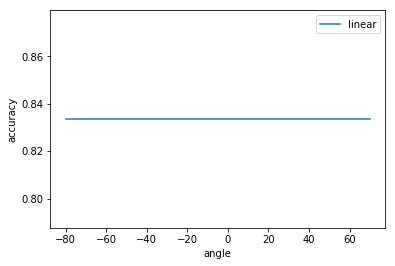

In [49]:
plt.plot(df['z'], df['accuracy'], label='linear')
plt.xlabel('angle')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [59]:
z = 1

In [60]:
a = np.array(z)

In [62]:
def skew(X, z):
    if not hasattr(z, "__len__"):
        z = np.ones(X.shape[0]) * z
    X_rotated = np.empty_like(X)
    for i in range(X.shape[0]):
        x = X[i].reshape(28,28)
        img = Image.fromarray(x)
        img = img.rotate(z[i], resample=Image.BICUBIC)
        x = np.array(img)
        X_rotated[i] = x.reshape(28,28,1)
    return X_rotated

In [66]:
z = np.random.normal( loc=0, scale=15, size=(X.shape[0]) )
baba = skew(X, z)

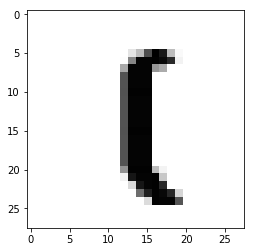

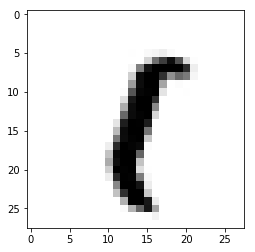

In [69]:
i = np.random.randint(0, X.shape[0])
plt.imshow(X[i].reshape(28,28), cmap='Greys')
plt.show()
plt.imshow(baba[i].reshape(28,28), cmap='Greys')
plt.show()
